<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Logistic-Regression-in-Python" data-toc-modified-id="Logistic-Regression-in-Python-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Logistic Regression in Python</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Prepare-the-data" data-toc-modified-id="Prepare-the-data-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Prepare the data</a></span></li></ul></li><li><span><a href="#Perform-stats-on-the-data" data-toc-modified-id="Perform-stats-on-the-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Perform stats on the data</a></span></li><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Train the model</a></span></li><li><span><a href="#Predict" data-toc-modified-id="Predict-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Predict</a></span></li></ul></li></ul></div>

# Logistic Regression in Python

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the data
world_data = pd.read_csv('micro_world.csv', engine='python')

In [3]:
# Filter Philippine data
philippine_data = world_data[
    world_data['economy'] == 'Philippines'
]

### Prepare the data

Let's use **gender**, **income group** and **educational background** as features for the prediction of **debit card ownership**.

Note that these are all categorical data.

In [4]:
# Filter data
data = philippine_data[
    [
        'female',
        'educ',
        'inc_q',
        'fin2'
    ]
]

In [5]:
# Show data
data

,female,educ,inc_q,fin2
114292,2,1.0,1,2
114293,2,3.0,5,1
114294,2,1.0,4,1
114295,2,2.0,5,1
114296,2,3.0,5,1
...,...,...,...,...
115287,1,2.0,1,2
115288,1,1.0,1,2
115289,2,2.0,4,2
115290,1,2.0,4,2


According to the data documentation, here's the meaning of the encoded values per column: 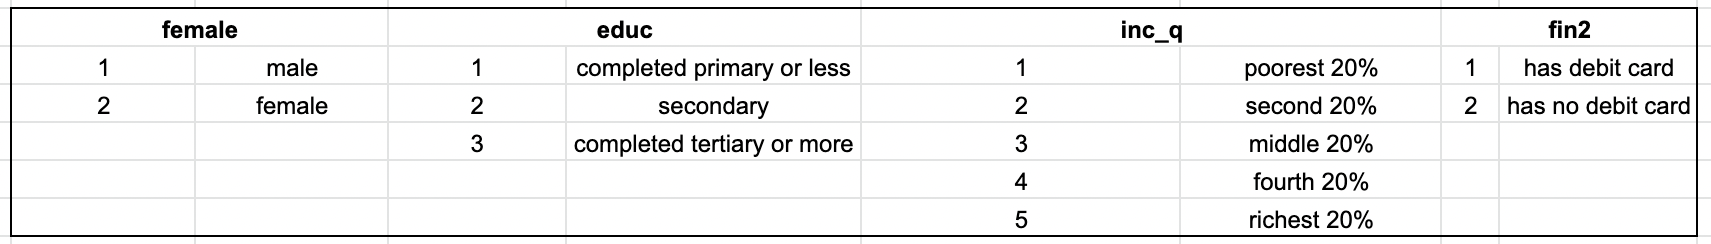

Let us check the distribution of unique values per column. 

In [6]:
# Check female column
data['female'].value_counts()

2    562
1    438
Name: female, dtype: int64

In [7]:
# Check educ column
data['educ'].value_counts()

2.0    594
1.0    292
3.0    114
Name: educ, dtype: int64

In [8]:
# Chekc inq_q column
data['inc_q'].value_counts()

5    228
4    209
3    203
1    192
2    168
Name: inc_q, dtype: int64

In [9]:
# Check fin2 column
data['fin2'].value_counts()

2    765
1    234
4      1
Name: fin2, dtype: int64

Notice that in fin2 column, there is one record with value of 4. According to the documentation, it seems that the respondent refused to answer. 

For now, let's replace this with 2. That is, we will assume this respondent has no debit card.

In [10]:
# Replace 4 with 2 in fin2 column
data['fin2'] = data['fin2'].replace({4:2})

C:\Users\emers\AppData\Local\Temp\ipykernel_376\2810368329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['fin2'] = data['fin2'].replace({4:2})


In [11]:
# Check again the fin2 column value distribution
data['fin2'].value_counts()

2    766
1    234
Name: fin2, dtype: int64

Now, let's make the column names more readable.

In [12]:
# Rename columns
data = data.rename(
    columns = {
        'female': 'gender',
        'educ':'educational_background', 
        'inc_q':'income_group',
        'fin2': 'has debit card'
        }
)

In [13]:
# Show data
data

,gender,educational_background,income_group,has debit card
114292,2,1.0,1,2
114293,2,3.0,5,1
114294,2,1.0,4,1
114295,2,2.0,5,1
114296,2,3.0,5,1
...,...,...,...,...
115287,1,2.0,1,2
115288,1,1.0,1,2
115289,2,2.0,4,2
115290,1,2.0,4,2


## Perform stats on the data

We can use various techniques to test the predictive power of our features.

For now, let's try to do **chi-square test of independence**. 

For each feature, we want to test if they are independent. 

In chi-square test of independence:
*   Null hypothesis, Ho: there is no relationship between x and y.
*   Alternative hypothesis, Ha: there is a relationship between x and y.

If p < 0.05, then we reject the null hypothesis in favor of the alternative hypothesis. In this case, we can use the feature in our logistic regression modeling because x has a significant relationship with y. 

In [14]:
# Import the library
from sklearn.feature_selection import chi2

In [15]:
# Separate features and labels
X = data.drop('has debit card',axis=1)
y = data['has debit card']

In [16]:
# Run chi-square test
chi_scores = chi2(X, y)

In [17]:
# Create a dataframe for mapping p-values to features
p_values = pd.Series(
    chi_scores[1],
    index = X.columns
    )
p_values.sort_values(
    ascending = False, 
    inplace = True
    )

In [18]:
# Display data
p_values

gender                    8.339401e-01
educational_background    1.045321e-05
income_group              1.089158e-14
dtype: float64

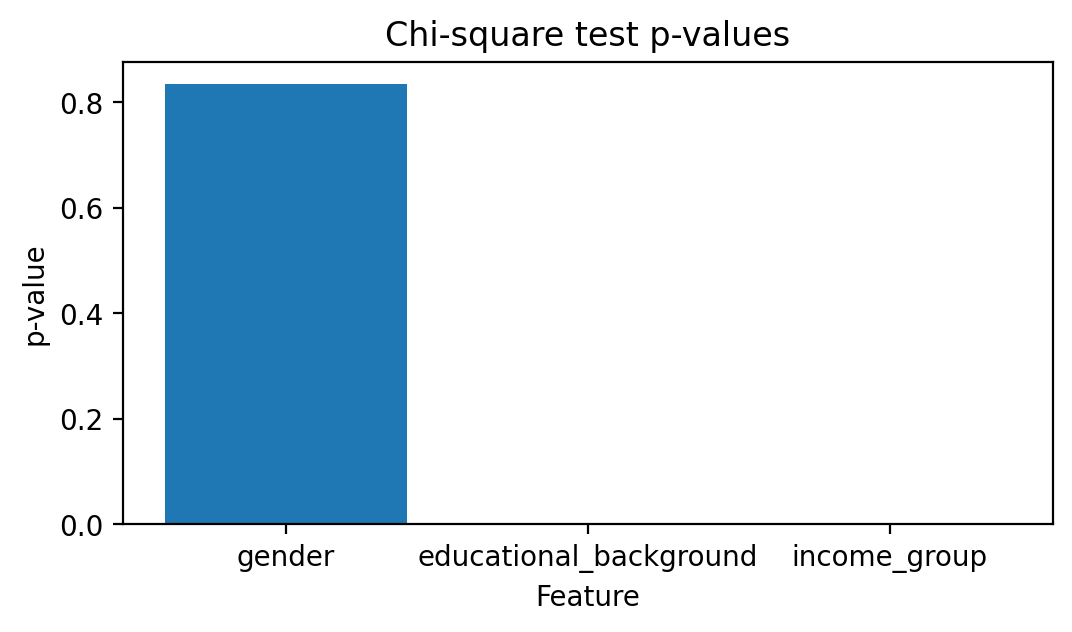

In [19]:
# Plot p-values per feature
plt.figure(figsize=(6,3)  , dpi=200)

# Run bar plot
plt.bar(
    p_values.index,
    p_values.values
)

# Set title
plt.title('Chi-square test p-values')

# Set labels
plt.xlabel('Feature')
plt.ylabel('p-value')

# Show figure
plt.show()

Based on this, it seems we can only use educational background and income group as candidate features for predicting debit card ownership.

## Train the model

In [20]:
# Reconfigure features and labels
X = data[['educational_background', 'income_group']]
y = data['has debit card']

Now, we will apply train-test split. We will use the training data in training the model and we will set aside the test data for the evaluation of our modle performance. Usual train-test split are as follows:

* 80/20 split: 80% training data, 20% test data
* 70/30 split: 70% training data, 30% test data

To put it simply, the essence of setting aside a test data is that we want to have a gauge of the model performance on the data it has not seen yet.

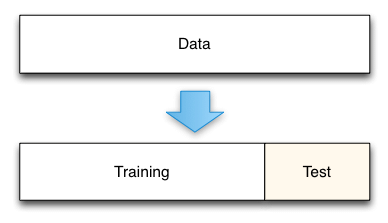

In [21]:
# Apply train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
    )

In [22]:
# Check imbalance
y_train.value_counts()

2    608
1    192
Name: has debit card, dtype: int64

Data is highly imbalanced.

There is a lot of people without debit cards. If we don't correct this, the model will inevitably be biased towards people WITHOUT debit cards.

We can do either (1) undersampling or (2) oversampling.

**Undersampling**: reduce the majority class to match the minority.

**Oversampling**: create synthetic copies of data points of the minority class to match the majority.

Luckily, Logistic Regression of scikit-learn can do this for us by passing class_weight='balanced'.

In [23]:
# Call the model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    random_state=42,
    class_weight='balanced'
    )

In [24]:
# Fit the model
trained_model = model.fit(X_train, y_train)

Note the difference between model and trained_model.

The model is only a set of code. Meanwhile, trained_model can be thought of as code + data. 

Now, we can move to making predictions.

## Predict

In [25]:
# Predict using the trained models
predictions = trained_model.predict(X_test)

To evaluate model performance, we can first prepare a confusion matrix.

In [26]:
# Set the true and predicted values
y_true = y_test
y_pred = predictions

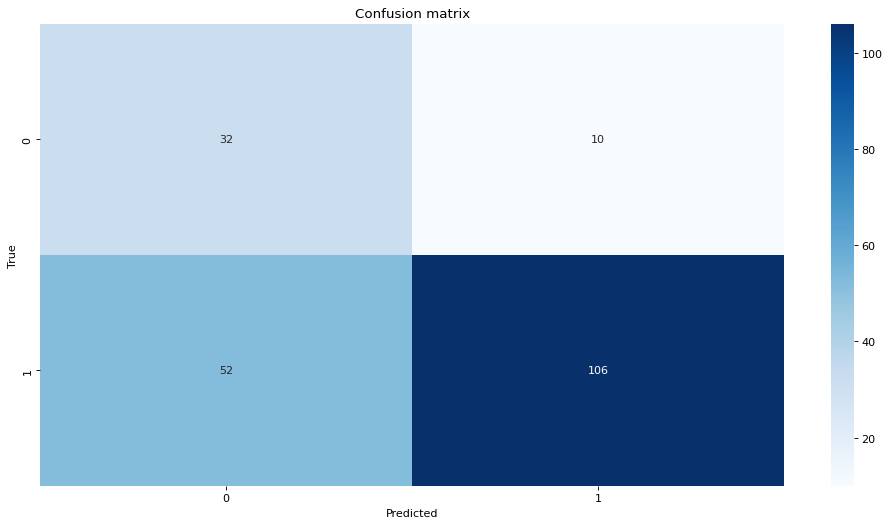

In [27]:
# Display confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15,7.5), dpi=80)
plt.title('Confusion matrix')
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

It seems the model was able to perform pretty okay. Now, let's check the classification metrics.

In [28]:
# Display evaluation metrics
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.38      0.76      0.51        42
           2       0.91      0.67      0.77       158

    accuracy                           0.69       200
   macro avg       0.65      0.72      0.64       200
weighted avg       0.80      0.69      0.72       200



Based on precision and recall, the model was able to predict the non-debit card owners correctly compared to debit card owners.

Overall, accuracy is 69% which is still better than a random classifier (with accuracy around 50%).